In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import LSTM, Dense, Input, GlobalAveragePooling2D, Attention, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [5]:
data_dir = "C:/Users/ASUS/Desktop/deepfake/prc"

In [6]:
batch_size = 32
img_size = (224, 224)
num_classes = 2 

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset='both',
    seed=123
)

Found 2432 files belonging to 2 classes.
Using 1946 files for training.
Using 486 files for validation.


In [8]:
train_dataset = dataset[0]
val_dataset = dataset[1]

In [9]:
# Optionally create a separate test dataset
test_dataset = val_dataset.take(int(0.5 * len(val_dataset)))
val_dataset = val_dataset.skip(int(0.5 * len(val_dataset)))

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

In [11]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [14]:
def create_resnet_model(input_shape):
    base_model = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
    x = GlobalAveragePooling2D()(base_model.output)
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [15]:
def create_attention_lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    lstm_out = LSTM(128, return_sequences=True)(input_layer)
    attention = Attention()([lstm_out, lstm_out])
    x = tf.reduce_mean(attention, axis=1)
    model = Model(inputs=input_layer, outputs=x)
    return model

In [16]:
resnet_input_shape = (img_size[0], img_size[1], 3)
resnet_model = create_resnet_model(resnet_input_shape)

In [20]:
from tensorflow.keras.layers import  Layer

In [22]:
def create_attention_lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    lstm_out = LSTM(128, return_sequences=True)(input_layer)
    attention = Attention()([lstm_out, lstm_out])
    x = tf.reduce_mean(attention, axis=1)
    model = Model(inputs=input_layer, outputs=x)
    return model

In [24]:
class CombinedModel(tf.keras.Model):
    def __init__(self, resnet_model, lstm_model):
        super(CombinedModel, self).__init__()
        self.resnet_feature_extractor = ResNetFeatureExtractor(resnet_model)
        self.lstm_model = lstm_model

    def call(self, inputs):
        features = self.resnet_feature_extractor(inputs)
        lstm_features = self.lstm_model(features)
        return lstm_features

In [27]:
attention_lstm_layer = AttentionLSTM()

In [28]:
combined_model = CombinedModel(resnet_model, attention_lstm_layer)

In [38]:
class AttentionLSTM(Layer):
    def __init__(self, lstm_units=128):
        super(AttentionLSTM, self).__init__()
        self.lstm = LSTM(lstm_units, return_sequences=True)
        self.attention = Attention()

    def call(self, inputs):
        lstm_out = self.lstm(inputs)
        tf.print("LSTM output shape:", tf.shape(lstm_out))
        
        attention_out = self.attention([lstm_out, lstm_out])
        tf.print("Attention output shape:", tf.shape(attention_out))
        
        return tf.reduce_mean(attention_out, axis=1)

In [33]:
class ResNetFeatureExtractor(Layer):
    def __init__(self, resnet_model):
        super(ResNetFeatureExtractor, self).__init__()
        self.resnet_model = resnet_model

    def call(self, inputs):
        # Check if inputs have 4 or 5 dimensions
        if len(inputs.shape) == 4:
            # Reshape to (batch_size, time_steps, height, width, channels) with time_steps=1
            inputs = tf.expand_dims(inputs, axis=1)
        elif len(inputs.shape) != 5:
            raise ValueError("Expected input to be 4D or 5D, but got shape: {}".format(inputs.shape))

        # Reshape to (batch_size * time_steps, height, width, channels) for ResNet processing
        batch_size, time_steps, height, width, channels = tf.shape(inputs)
        inputs = tf.reshape(inputs, (-1, height, width, channels))

        # Extract features using ResNet
        features = self.resnet_model(inputs)

        # Reshape features back to (batch_size, time_steps, feature_dim)
        features = tf.reshape(features, (batch_size, time_steps, -1))
        return features

In [39]:
def extract_features(dataset, combined_model):
    features = []
    labels = []

    for images, label in dataset:
        images_np = images.numpy()
        label_np = label.numpy()
        
        tf.print("Images shape before feature extraction:", tf.shape(images))
        batch_features = combined_model(images_np, training=False)
        tf.print("Batch features shape:", tf.shape(batch_features))
        
        features.append(batch_features)
        labels.append(label_np)

    features = np.concatenate([f for f in features], axis=0)
    labels = np.concatenate(labels, axis=0)

    return features, labels

In [40]:
# Create dummy data
dummy_images = tf.random.normal([batch_size, 1, img_size[0], img_size[1], 3])
dummy_labels = tf.random.uniform([batch_size], maxval=num_classes, dtype=tf.int32)

# Test ResNetFeatureExtractor
feature_extractor = ResNetFeatureExtractor(resnet_model)
extracted_features = feature_extractor(dummy_images)
tf.print("Extracted features shape:", tf.shape(extracted_features))

# Test AttentionLSTM
attention_lstm = AttentionLSTM()
lstm_features = attention_lstm(extracted_features)
tf.print("LSTM features shape:", tf.shape(lstm_features))


Extracted features shape: [32 1 2048]
LSTM output shape: [32 1 128]
Attention output shape: [32 1 128]
LSTM features shape: [32 128]


In [42]:
for images, labels in train_dataset.take(1):
    print("Train images shape:", images.shape)
    print("Train labels shape:", labels.shape)
for images, labels in val_dataset.take(1):
    print("Val images shape:", images.shape)
    print("Val labels shape:", labels.shape)
for images, labels in test_dataset.take(1):
    print("Test images shape:", images.shape)
    print("Test labels shape:", labels.shape)


Train images shape: (32, 224, 224, 3)
Train labels shape: (32,)
Val images shape: (32, 224, 224, 3)
Val labels shape: (32,)
Test images shape: (32, 224, 224, 3)
Test labels shape: (32,)


In [43]:
tf.config.run_functions_eagerly(True)

In [45]:
def create_resnet_model(input_shape):
    base_model = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
    x = GlobalAveragePooling2D()(base_model.output)
    model = Model(inputs=base_model.input, outputs=x)
    return model

resnet_input_shape = (224, 224, 3)
resnet_model = create_resnet_model(resnet_input_shape)

class ResNetFeatureExtractor(Layer):
    def __init__(self, resnet_model):
        super(ResNetFeatureExtractor, self).__init__()
        self.resnet_model = resnet_model

    def call(self, inputs):
        if len(inputs.shape) == 4:
            inputs = tf.expand_dims(inputs, axis=1)
        elif len(inputs.shape) != 5:
            raise ValueError("Expected input to be 4D or 5D, but got shape: {}".format(inputs.shape))

        batch_size, time_steps, height, width, channels = tf.shape(inputs)
        inputs = tf.reshape(inputs, (-1, height, width, channels))
        features = self.resnet_model(inputs)
        features = tf.reshape(features, (batch_size, time_steps, -1))
        return features

class AttentionLSTM(Layer):
    def __init__(self, lstm_units=128):
        super(AttentionLSTM, self).__init__()
        self.lstm = LSTM(lstm_units, return_sequences=True)
        self.attention = Attention()

    def call(self, inputs):
        lstm_out = self.lstm(inputs)
        attention_out = self.attention([lstm_out, lstm_out])
        return tf.reduce_mean(attention_out, axis=1)

class CombinedModel(tf.keras.Model):
    def __init__(self, resnet_model, attention_lstm):
        super(CombinedModel, self).__init__()
        self.resnet_feature_extractor = ResNetFeatureExtractor(resnet_model)
        self.attention_lstm = attention_lstm

    def call(self, inputs):
        features = self.resnet_feature_extractor(inputs)
        lstm_features = self.attention_lstm(features)
        return lstm_features

attention_lstm_layer = AttentionLSTM()
combined_model = CombinedModel(resnet_model, attention_lstm_layer)

def extract_features(dataset, combined_model):
    features = []
    labels = []

    for images, label in dataset:
        try:
            print("Batch images shape:", images.shape)
            print("Batch labels shape:", label.shape)
            
            batch_features = combined_model(images, training=False)
            
            print("Batch features shape:", batch_features.shape)
            
            features.append(batch_features)
            labels.append(label)
        except Exception as e:
            print("Error:", e)
            break

    features = np.concatenate([f.numpy() for f in features], axis=0)
    labels = np.concatenate([l.numpy() for l in labels], axis=0)

    return features, labels

# Example usage with dummy data
train_features, train_labels = extract_features(small_train_dataset, combined_model)
val_features, val_labels = extract_features(small_val_dataset, combined_model)
test_features, test_labels = extract_features(small_test_dataset, combined_model)

Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Ba

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (6, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Batch features shape: (6, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)


In [46]:
train_features, train_labels = extract_features(train_dataset, combined_model)
val_features, val_labels = extract_features(val_dataset, combined_model)
test_features, test_labels = extract_features(test_dataset, combined_model)

Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Ba

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (26, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Batch features shape: (26, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (6, 224, 224, 3)
Batch labels shape: (6,)
Batch features shape: (6, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)
Batch features shape: (32, 128)
Batch image

In [48]:
meta_learner = make_pipeline(StandardScaler(), LogisticRegression())
meta_learner.fit(train_features, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [49]:
val_predictions = meta_learner.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f'Validation Accuracy: {val_accuracy:.2f}')

Validation Accuracy: 0.85


In [50]:
test_predictions = meta_learner.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy:.2f}')

Test Accuracy: 0.87


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Assuming you have your test predictions and true labels
test_predictions = meta_learner.predict(test_features)

# Print classification report including precision, recall, and f1-score
report = classification_report(test_labels, test_predictions, target_names=['Class 0', 'Class 1'])
print(report)

# Compute individual metrics
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


              precision    recall  f1-score   support

     Class 0       0.84      0.90      0.87       125
     Class 1       0.90      0.84      0.87       131

    accuracy                           0.87       256
   macro avg       0.87      0.87      0.87       256
weighted avg       0.87      0.87      0.87       256

Precision: 0.87
Recall: 0.87
F1 Score: 0.87


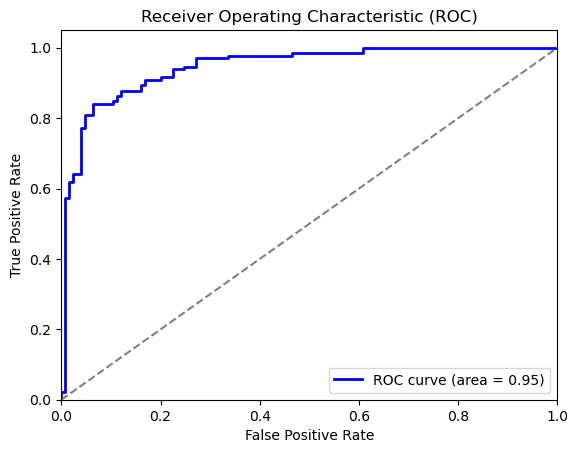

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_prob = meta_learner.predict_proba(test_features)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(test_labels, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

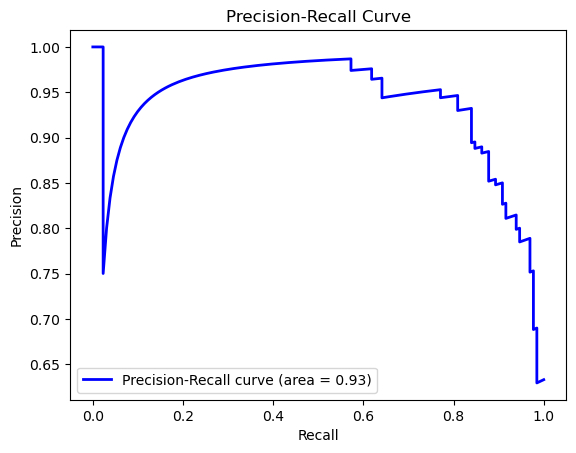

In [53]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(test_labels, y_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [54]:
# Save the entire model
combined_model.save('path_to_your_model/combined_model.h5')